## 範例重點
* 學習如何在 keras 中加入 model checkpoint
* 知道如何設定監控目標
* 比較使用最佳與非最佳參數時的 performance

In [1]:
import os
import keras


Using TensorFlow backend.
/Users/liaoshousan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/liaoshousan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/liaoshousan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/liaoshousan/opt/ana

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

In [9]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("./tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512 

Epoch 46/50
50000/50000 [==============================] - 17s 336us/step - loss: 0.5642 - accuracy: 0.8350 - val_loss: 1.6419 - val_accuracy: 0.4789
Epoch 47/50
50000/50000 [==============================] - 14s 270us/step - loss: 0.5467 - accuracy: 0.8408 - val_loss: 1.6411 - val_accuracy: 0.4869
Epoch 48/50
50000/50000 [==============================] - 20s 396us/step - loss: 0.5302 - accuracy: 0.8483 - val_loss: 1.6639 - val_accuracy: 0.4815
Epoch 49/50
50000/50000 [==============================] - 20s 403us/step - loss: 0.5112 - accuracy: 0.8569 - val_loss: 1.6869 - val_accuracy: 0.4805
Epoch 50/50
10000/10000 [==============================] - 3s 315us/step


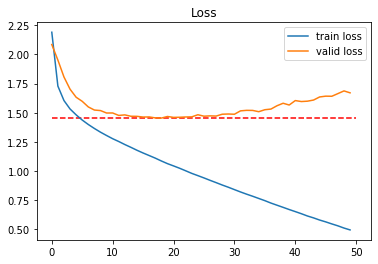

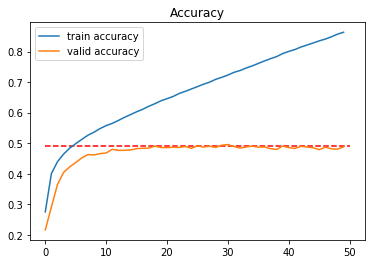

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

## save_weights_only = True, 並輸出為temp_2.h5

In [15]:
from keras.callbacks import ModelCheckpoint

model_ckpt_2 = ModelCheckpoint(filepath="./tmp_2.h5", 
                             monitor="val_loss", 
                             save_best_only=True,
                              save_weights_only = True)

In [28]:
model_2 = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model_2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model_2.fit(x_train, y_train, 
          epochs=50, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_2]
         )

# Collect results
train_loss = model_2.history.history["loss"]
valid_loss = model_2.history.history["val_loss"]
train_acc = model_2.history.history["accuracy"]
valid_acc = model_2.history.history["val_accuracy"]



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512 

50000/50000 [==============================] - 20s 397us/step - loss: 0.5692 - accuracy: 0.8297 - val_loss: 1.6273 - val_accuracy: 0.4870
Epoch 47/50
50000/50000 [==============================] - 21s 416us/step - loss: 0.5516 - accuracy: 0.8403 - val_loss: 1.6413 - val_accuracy: 0.4897
Epoch 48/50
50000/50000 [==============================] - 19s 372us/step - loss: 0.5344 - accuracy: 0.8459 - val_loss: 1.6277 - val_accuracy: 0.4946
Epoch 49/50
50000/50000 [==============================] - 21s 410us/step - loss: 0.5157 - accuracy: 0.8534 - val_loss: 1.6336 - val_accuracy: 0.4940
Epoch 50/50
50000/50000 [==============================] - 15s 306us/step - loss: 0.5013 - accuracy: 0.8584 - val_loss: 1.6944 - val_accuracy: 0.4871


In [29]:
model_2 = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model_2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512 

### 將temp_2.h5載入模型

In [30]:
# Load back
model_2.load_weights("./tmp_2.h5")
loss_loadback_2, acc_loadback_2 = model_2.evaluate(x_test, y_test)


10000/10000 [==============================] - 5s 464us/step
